LOJİSTİK REGRESYON

In [ ]:
# lojistik regresyonda yapılan tahmminler 1 sınıfına göre olasılıkları gösterir.

Confusion Matrix

In [ ]:
# gerçek sınıflardaki 1 ve 0' ın tahmin edilen sınıflardaki 1 ve 0'lara göre karmaşıklık matrisidir.
# gerçek 1 ve tahmin 1 -> true pozitif
# gerçek 0 ve tahmin 0 -> true negatif
# gerçek 1 ve tahmin 0 -> false negatif
# gerçek 0 ve tahmin 1 -> false pozitif

Confuison Matrix' e Göre Skorlar

In [ ]:
# Accuracy -> Doğru sınıflandırma oranı  (TP+TN)/(TP+TN+FP+FN)
# Precision -> Pozitif sınıf tahminlerinin başarı oranı (tahmin ettiklerimizin ne kadarı doğru)  TP/(TP+FP)
# Recall -> Pozitif sınıfın doğru tahmin edilme oranı (işlemleri ne kadar doğru tahmin ettik)  TP/(TP+FN)
# F1 -> İkisinin harmonik ortalamasını gösterir  2*(Precision*Recall)/(Precision+Recall)

# FP -> 1. tip hata (basit hata)
# FN -> 2. tip hata (kritik hata)

Classification Threshold

In [ ]:
# Skorlarda başarı eşiği demektir, genelde 0.50 olarak ele alınır.  0.50 den büyükse sınıf 1 değilse sınıf 0' a atanır.

Roc Eğrisi

In [ ]:
# tp, fp ye göre düzlem çizilir ve olası bütün thresholdlar denenir. Bu thresholdlara göre eğri çizilir, eğri ne kadar yukarı doğru olursa o kadar iyi.
# AUC -> roc eğrisinin altında kalan alan demek.

Diabets Veri Seti

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, RocCurveDisplay, classification_report, roc_auc_score

Keşifçi Veri Analizi

In [ ]:
df = pd.read_csv('diabetes.csv')
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [ ]:
# Target Analizi
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


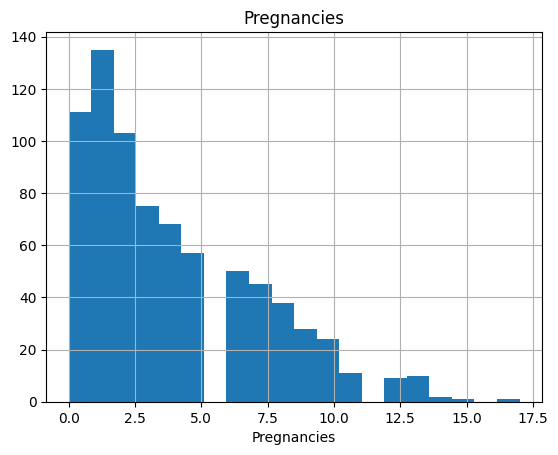

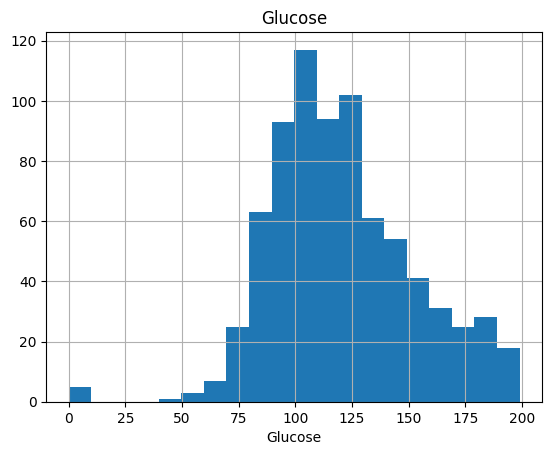

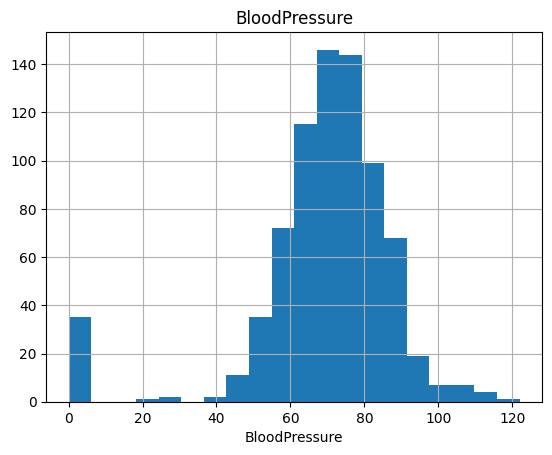

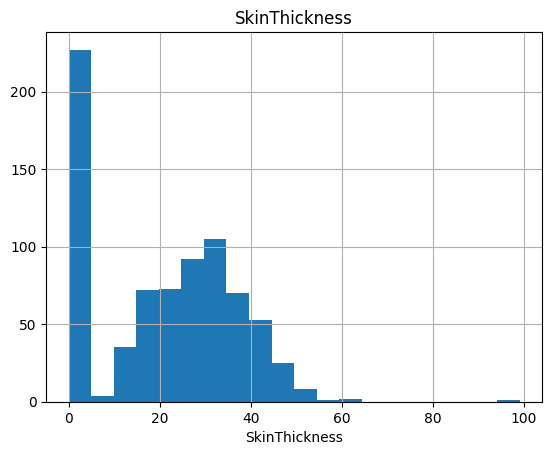

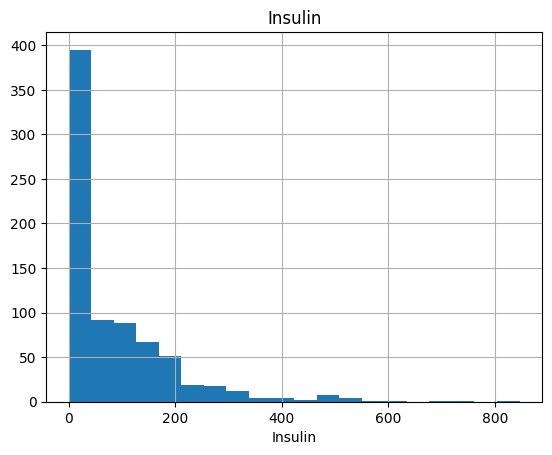

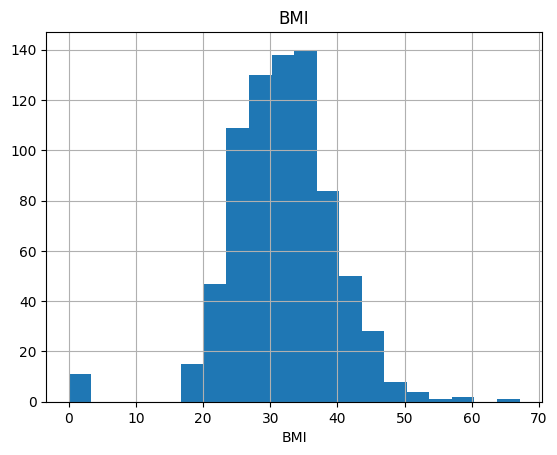

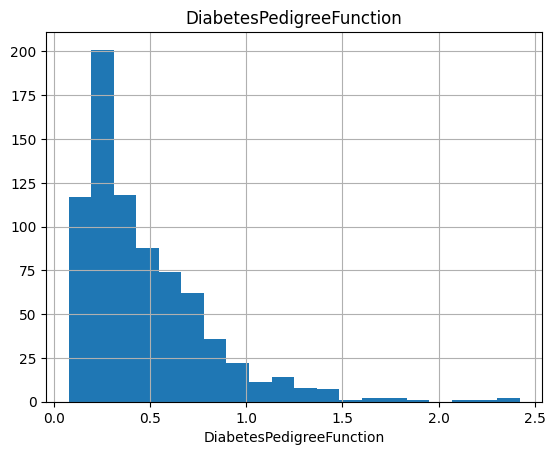

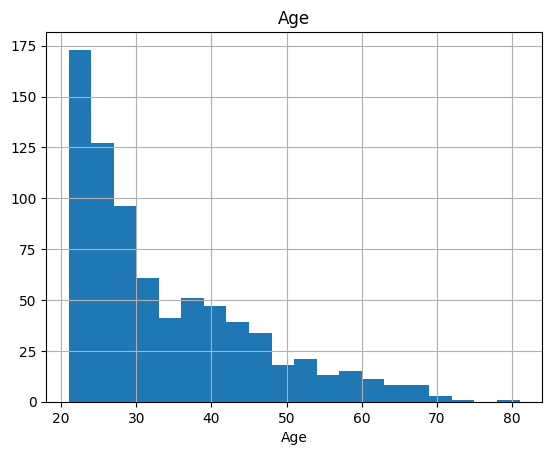

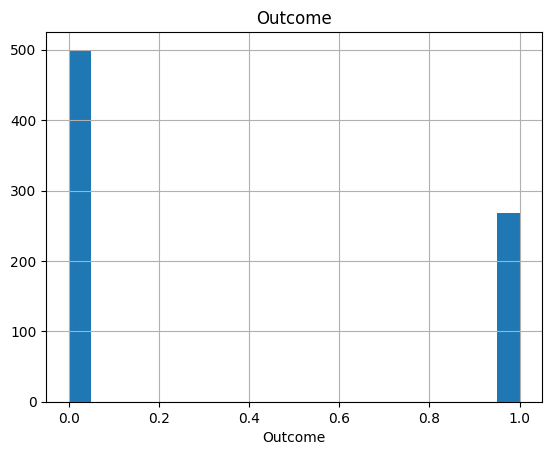

In [ ]:
# Feature Analizi
df.describe().T
def plot_numerical_col(df, numerical_col):
    df.hist(numerical_col, bins = 20)
    plt.xlabel(numerical_col)
    plt.show(block=True)
for col in df.columns:
    plot_numerical_col(df, col)

In [ ]:
# Target vs Feature
def target_summary_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")
for col in df.columns:
    target_summary_num(df, 'Outcome', col)

         Pregnancies
Outcome             
0               3.30
1               4.87


         Glucose
Outcome         
0         109.98
1         141.26


         BloodPressure
Outcome               
0                68.18
1                70.82


         SkinThickness
Outcome               
0                19.66
1                22.16


         Insulin
Outcome         
0          68.79
1         100.34


          BMI
Outcome      
0       30.30
1       35.14


         DiabetesPedigreeFunction
Outcome                          
0                            0.43
1                            0.55


          Age
Outcome      
0       31.19
1       37.07


         Outcome
Outcome         
0           0.00
1           1.00




Veri Ön İşleme

In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quantile1 = dataframe[col_name].quantile(q1)
    quantile3 = dataframe[col_name].quantile(q3)
    iqr = quantile3 - quantile1
    up_limit = quantile3 + 1.5 * iqr
    low_limit = quantile1 - 1.5 * iqr
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

for col in df.columns:
    print(col, check_outlier(df, col))

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

for col in df.columns:
    replace_with_thresholds(df, col)

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False
Outcome False


<ipython-input-30-608fdcd9335a>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-38.249999999999986' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
<ipython-input-30-608fdcd9335a>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-439.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
<ipython-input-30-608fdcd9335a>:21: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-34.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dataframe.loc[(dataframe[variable] < low_limit), variable] =

In [ ]:
# Scale İşlemi
scaler = RobustScaler()
df[df.columns] = scaler.fit_transform(df[df.columns])
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.60,0.75,0.00,0.38,-0.24,0.17,0.67,1.24,1.00
1,-0.40,-0.78,-0.33,0.19,-0.24,-0.58,-0.06,0.12,0.00
2,1.00,1.60,-0.44,-0.72,-0.24,-0.94,0.78,0.18,1.00
3,-0.40,-0.68,-0.33,0.00,0.50,-0.42,-0.54,-0.47,0.00
4,-0.60,0.48,-1.78,0.38,1.08,1.19,5.01,0.24,1.00


In [ ]:
# Model & Predict
y = df['Outcome']
x = df.drop('Outcome', axis = 1)
log_model = LogisticRegression().fit(x,y)
y_pred = log_model.predict(x)
y_pred[0:10]
y[0:10]

,Outcome
0,1.00
1,0.00
2,1.00
3,0.00
4,1.00
5,0.00
6,1.00
7,0.00
8,1.00
9,1.00


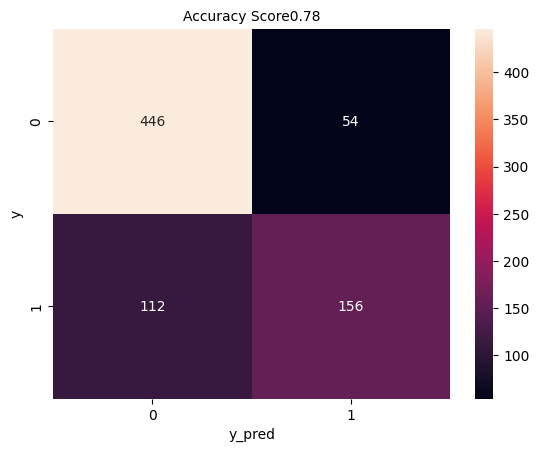

In [ ]:
# Model Başarı Değerlendirme
def plot_confusion_matrix(y, y_pred):
  acc = round(accuracy_score(y, y_pred), 2)
  cm = confusion_matrix(y, y_pred)
  sns.heatmap(cm, annot=True, fmt=".0f")
  plt.xlabel('y_pred')
  plt.ylabel('y')
  plt.title('Accuracy Score{0}'.format(acc), size=10)
  plt.show()

plot_confusion_matrix(y, y_pred)


In [ ]:
# Roc Auc Değeri
y_prob = log_model.predict_proba(x)[:,1]
roc_auc_score(y, y_prob)

0.8394104477611941

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 17)
log_model = LogisticRegression().fit(x_train, y_train)

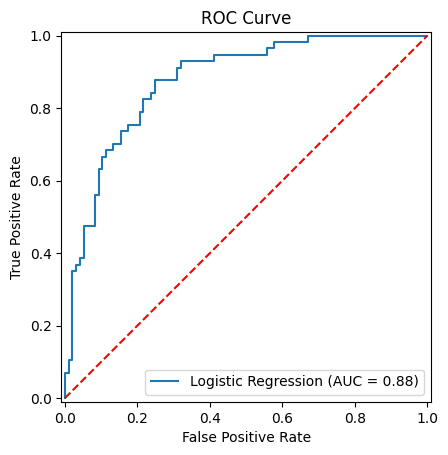

In [ ]:
from sklearn.metrics import roc_curve, auc

# ROC eğrisi ve AUC değeri hesaplama
y_prob = log_model.predict_proba(x_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# RocCurveDisplay ile ROC eğrisini çizme
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
display.plot()

plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

K-Katlı Çapraz Doğrulama

In [ ]:
x = df.drop('Outcome', axis = 1)
y = df['Outcome']
log_model = LogisticRegression().fit(x,y)
cv_results = cross_validate(log_model, x, y, cv = 5, scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

cv_results['test_accuracy'].mean()
# 0.7721
cv_results['test_precision'].mean()
# 0.7192
cv_results['test_recall'].mean()
# 0.5747
cv_results['test_f1'].mean()
# 0.6371
cv_results['test_roc_auc'].mean()
# 0.8328

0.832879105520615